PREDICTING WITH CONVOLUTIONAL NEURAL NETWORKS

---




### 1. Google Colab runtime setup [Optional]

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Clone and install spectrai package 
!git clone https://github.com/franckalbinet/spectrai.git 
!pip install /content/spectrai 

Cloning into 'spectrai'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 216 (delta 47), reused 84 (delta 25), pack-reused 99
Receiving objects: 100% (216/216), 76.51 MiB | 24.43 MiB/s, done.
Resolving deltas: 100% (53/53), done.
Checking out files: 100% (97/97), done.
Processing ./spectrai
     |████████████████████████████████| 20.0MB 1.7MB/s 
     |████████████████████████████████| 10.1MB 161kB/s 
     |████████████████████████████████| 6.7MB 35.4MB/s 
     |████████████████████████████████| 25.2MB 129kB/s 
     |████████████████████████████████| 225kB 37.2MB/s 
     |████████████████████████████████| 86.3MB 81kB/s 
     |████████████████████████████████| 112kB 42.5MB/s 
     |████████████████████████████████| 675kB 40.4MB/s 
     |████████████████████████████████| 102kB 10.4MB/s 
     |████████████████████████████████| 71kB 6.9MB/s 
     |████████████████████████████████| 450kB 

In [ ]:
# Prepare /root folder content
!cp -r /content/drive/My\ Drive/Colab\ Notebooks/data/data_spectrai /root

In [ ]:
# Create configuration file
!mkdir /root/.spectrai_config & cp /content/spectrai/config.toml /root/.spectrai_config

### 2. Import packages

In [ ]:
# To train on a GPU
!pip install tensorflow-gpu

     |████████████████████████████████| 320.4MB 52kB/s 
     |████████████████████████████████| 460kB 29.6MB/s 
     |████████████████████████████████| 26.1MB 93kB/s 
     |████████████████████████████████| 6.8MB 39.0MB/s 
ERROR: tensorflow 2.0.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: tensorflow 2.0.0 has requirement tensorboard<2.1.0,>=2.0.0, but you'll have tensorboard 2.3.0 which is incompatible.
ERROR: tensorflow 2.0.0 has requirement tensorflow-estimator<2.1.0,>=2.0.0, but you'll have tensorflow-estimator 2.3.0 which is incompatible.
ERROR: spectrai 0.0.3 has requirement scipy==1.3.2, but you'll have scipy 1.4.1 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: tensorflow-estimator 2.0.1
    Uninstalling tensorflow-estimator-2.0.1:
      Successfully uninstalled tensorflow-estimator-2.0.1
  Found existing installa

In [ ]:
from spectrai.datasets.kssl import (get_tax_orders_lookup_tbl, load_data)
from spectrai.vis.spectra import (plot_spectra)
from spectrai.metrics.keras import rpd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import numpy as np

from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers, models, Model
import tensorflow.keras.backend as K
import tensorflow.keras.utils as utils

import matplotlib.pyplot as plt

### 3. Load KSSL dataset

In [ ]:
# Loading Potassium, NH4OAc
# Loading data ("Potassium, NH4OAc: 725" or "CEC": 723 for instance)
X, X_names, y, y_names, instances_id = load_data(analytes=[725])

In [ ]:
print('X shape: ', X.shape)
print('X approx. memory size: {} MB'.format(X.nbytes // 10**6))
print('y approx. memory size: {} MB'.format(y.nbytes // 10**6))
print('Wavenumbers: ', X_names)
print('Target variable: ', y_names)

X shape:  (50714, 1764)
X approx. memory size: 357 MB
y approx. memory size: 1 MB
Wavenumbers:  [3999 3997 3995 ...  603  601  599]
Target variable:  ['lay_depth_to_top' 'order_id' 'calc_value']


(array([47701., 49993., 50636., 50725., 50727., 50728., 50731., 50731.,
        50731., 50732.]),
 array([  0.        ,  58.45865486, 116.91730972, 175.37596458,
        233.83461944, 292.2932743 , 350.75192916, 409.21058402,
        467.66923888, 526.12789374, 584.5865486 ]),
 <a list of 10 Patch objects>)

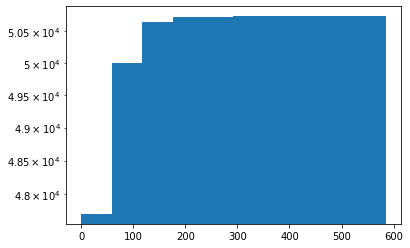

In [ ]:
plt.hist(y[:,-1], cumulative=True, log=True)

### 4. Data preparation

In [ ]:
# Keeping data with analyte concentration > 0 only and for 'alfisols' taxonomic order only.
#TAX_ORDER_ID = 0

idx_y_valid = y[:, -1] > 0
#idx_y_valid = (y[:, -1] > 0) & (y[:, -1] <= np.quantile(y[:, -1], 0.5))
#idx_order = y[:,1] == TAX_ORDER_ID
#idx = idx_y_valid & idx_order

X = X[idx_y_valid,:]
y = y[idx_y_valid,:]

# Scale data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [ ]:
# Creating train, valid, test sets
#X, X_test, y, y_test = train_test_split(X, y[:, -1], test_size=0.20, random_state=42)
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X, y[:, -1], test_size=0.2, random_state=42)

print('X test shape: ', X_test.shape)
print('y test shape: ', y_test.shape)
print('X valid shape: ', X_valid.shape)
print('X train shape: ', X_train.shape)
print('y train shape: ', y_train.shape)

X test shape:  (9728, 1764)
y test shape:  (9728, 3)
X valid shape:  (7782, 1764)
X train shape:  (31126, 1764)
y train shape:  (31126,)


### 5. Defining CNN model

In [ ]:
activation = 'relu'
input_dim = X_train.shape[1]

model = keras.models.Sequential()
model.add(layers.Reshape((input_dim, 1), input_shape=(input_dim,)))

model.add(layers.BatchNormalization())
model.add(layers.Conv1D(32, 30, activation=activation))
model.add(layers.MaxPool1D(4))

model.add(layers.BatchNormalization())
model.add(layers.Conv1D(64, 30, activation=activation))
model.add(layers.MaxPool1D(4))

model.add(layers.BatchNormalization())
model.add(layers.Conv1D(128, 30, activation=activation))
model.add(layers.MaxPool1D(4))

#model.add(layers.Dropout(rate=0.4))

model.add(layers.Flatten())

model.add(layers.BatchNormalization())
model.add(layers.Dense(100, activation=activation))

model.add(layers.BatchNormalization())
model.add(layers.Dense(50, activation=activation))

model.add(layers.BatchNormalization())
model.add(layers.Dense(10, activation=activation))

#model.add(layers.Dropout(rate=0.2))

model.add(layers.Dense(1,  activation='linear'))

model.compile(optimizer=RMSprop(learning_rate=1e-3), loss='mse', metrics=[rpd])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1764, 1)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1764, 1)           4         
_________________________________________________________________
conv1d (Conv1D)              (None, 1735, 32)          992       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 433, 32)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 433, 32)           128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 404, 64)           61504     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 101, 64)           0

### 6. Training the model

In [ ]:
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-4)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid))

Epoch 1/50
973/973 [==============================] - 21s 21ms/step - loss: 0.9795 - rpd: 1.1022 - val_loss: 0.7403 - val_rpd: 1.3500
Epoch 2/50
973/973 [==============================] - 20s 21ms/step - loss: 0.7464 - rpd: 1.3354 - val_loss: 0.7653 - val_rpd: 1.2762
Epoch 3/50
973/973 [==============================] - 21s 22ms/step - loss: 0.6535 - rpd: 1.4532 - val_loss: 0.6239 - val_rpd: 1.4774
Epoch 4/50
973/973 [==============================] - 21s 22ms/step - loss: 0.6080 - rpd: 1.5037 - val_loss: 0.6768 - val_rpd: 1.3612
Epoch 5/50
973/973 [==============================] - 21s 22ms/step - loss: 0.5558 - rpd: 1.5765 - val_loss: 0.5730 - val_rpd: 1.5804
Epoch 6/50
973/973 [==============================] - 21s 22ms/step - loss: 0.5215 - rpd: 1.6112 - val_loss: 0.5807 - val_rpd: 1.5381
Epoch 7/50
973/973 [==============================] - 21s 22ms/step - loss: 0.4923 - rpd: 1.6803 - val_loss: 0.5388 - val_rpd: 1.7226
Epoch 8/50
973/973 [==============================] - 20s 21ms

### 7. Saving model

In [ ]:
MODEL_PATH = '/content/drive/My Drive/Colab Notebooks/models/cnn-basic-50-epochs-cec.h5'
model.save(MODEL_PATH)

In [ ]:
MODEL_PATH = '/content/drive/My Drive/Colab Notebooks/models/cnn-basic-50-epochs-cec.h5'
model = models.load_model(MODEL_PATH, custom_objects={'rpd': rpd})

### 8. Assessing learning

In [ ]:
# Concat all runs history
def concat_history(*args):
  all_history = args[0].history.copy()
  for hist in args[1:]:
    for k in all_history.keys():
      all_history[k] += hist.history[k]
  return all_history

all_history = concat_history(history)

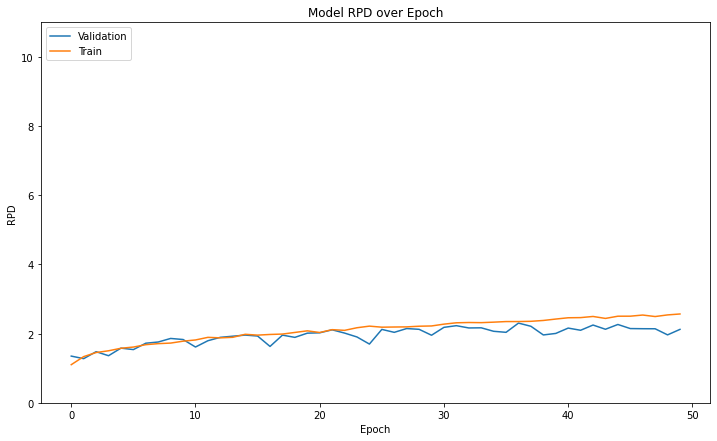

In [ ]:
# Plot training & validation accuracy values
fig, ax = plt.subplots(figsize=(12,7))
_ = ax.plot(all_history['val_rpd'])
_ = ax.plot(all_history['rpd'])
plt.ylim(0, 11)
plt.title('Model RPD over Epoch')
plt.ylabel('RPD')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Train'], loc='upper left')

In [ ]:
_, _rpd = model.evaluate(X_test, y_test[:, -1])
print('RPD on test set:', _rpd)

304/304 [==============================] - 2s 7ms/step - loss: 0.5128 - rpd: 1.9961
RPD on test set: 1.9960532188415527


In [ ]:
print('R2 on test set: ', r2_score(model.predict(X_test), y_test[:, -1]))

R2 on test set:  0.6437164160890516


### 9. Wavenumbers influence

Based on **"Convolutional neural network for simultaneous prediction of several soil properties using visible/near-infrared, mid-infrared, and their combined spectra"** paper: https://www.sciencedirect.com/science/article/abs/pii/S0016706119300588

In [ ]:
# 1. Draw 1000 samples from the test set
NB_SAMPLE = 1000
random_indices = np.random.choice(X_test.shape[0], size=NB_SAMPLE, replace=False)
X_test_sample = X_test[random_indices, :]
print(X_test_sample.shape)
 

(1000, 1764)


In [ ]:
# 2. Take the mean of all spectra
spectrum_mean = np.mean(X_test_sample, axis = 0).reshape(1, -1)
spectra_mean = np.repeat(spectrum_mean, repeats=NB_SAMPLE, axis=0)

In [ ]:
# 3. Perturbate spectra_mean with X_test_sample and take predictions variance
NB_WN = X_test_sample.shape[1]
predictions_variance = np.zeros(NB_WN)

for wn in range(NB_WN):
  spectra_var = np.copy(spectra_mean)
  spectra_var[:,wn] = X_test_sample[:,wn]
  predictions_variance[wn] = np.var(model.predict(spectra_var))

predictions_variance

array([1.44174228e-09, 1.02342168e-09, 4.90309882e-09, ...,
       1.09707801e-14, 1.09707801e-14, 1.09707801e-14])

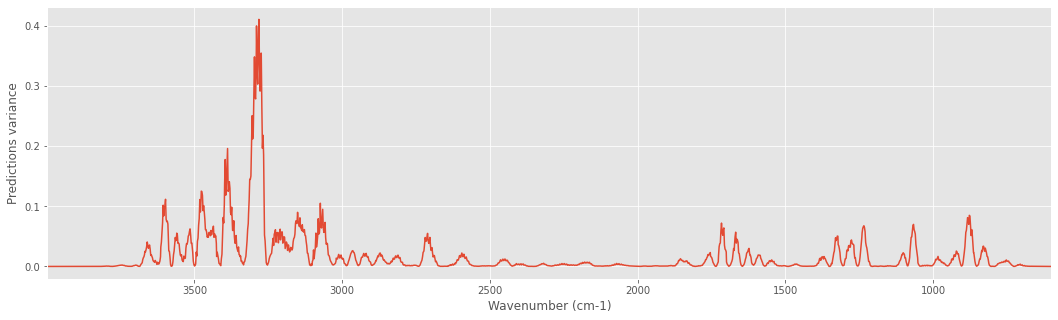

In [ ]:
def plot_variance(variance, X_names, figsize=(18, 5)):
  with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(np.max(X_names), np.min(X_names))
    plt.xlabel('Wavenumber (cm-1)')
    plt.ylabel('Predictions variance')
    _ = ax.plot(X_names, variance)

plot_variance(predictions_variance, X_names)


### 10. Error analysis 

In [ ]:
diff = np.abs(model.predict(X_test).ravel() - y_test)

In [ ]:
diff.shape

(9728,)

(array([9.594e+03, 1.020e+02, 1.300e+01, 1.200e+01, 4.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([1.19151554e-05, 1.53583196e+00, 3.07165201e+00, 4.60747206e+00,
        6.14329211e+00, 7.67911216e+00, 9.21493221e+00, 1.07507523e+01,
        1.22865723e+01, 1.38223924e+01, 1.53582124e+01]),
 <a list of 10 Patch objects>)

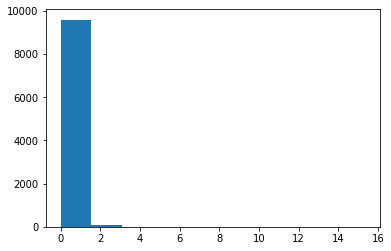

In [ ]:
plt.hist(diff, bins=10)